## 다중시계열 학습

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

c:\Users\pjy970108\AppData\Local\anaconda3\envs\base_env\Lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
AirPassengersDataset().load().time_index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

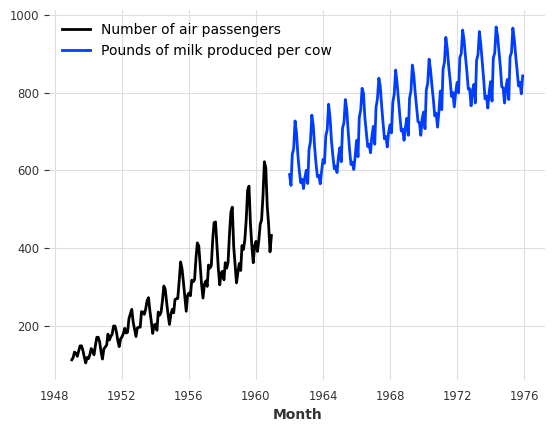

In [3]:
# 데이터 불러오기
# Time Series 형태
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();


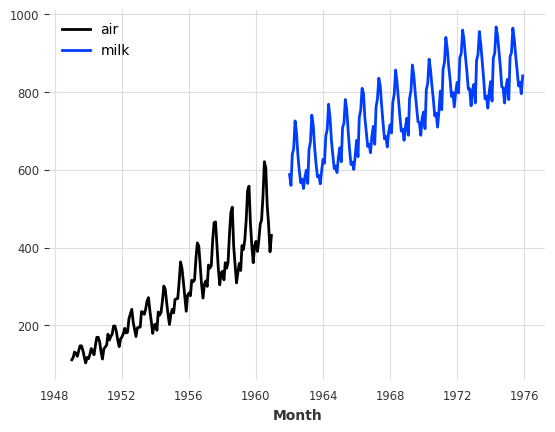

In [4]:
# Box-Cox 변환
# 데이터의 정규성을 개선하고 분산을 안정화하는 방법
from darts.dataprocessing.transformers import BoxCox

scaler_air, scaler_milk = BoxCox(lmbda=1), BoxCox(lmbda=1)
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

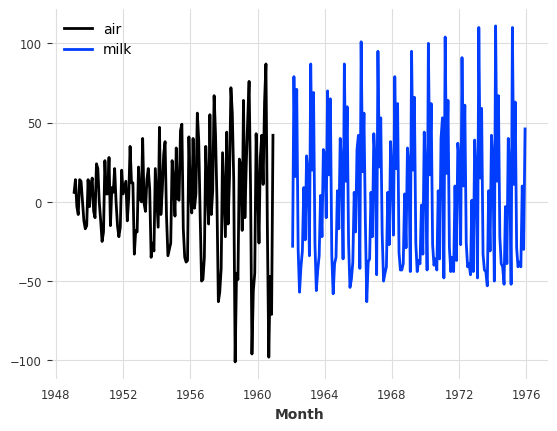

In [5]:
# 차분변환
# 시계열 데이터의 정상성을 확인하기 위해 차분변환을 수행
# 차분변환은 현재 시점의 데이터에서 이전 시점의 데이터를 뺀 값
from darts.dataprocessing.transformers import Diff
scaler_air, scaler_milk = Diff(), Diff()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

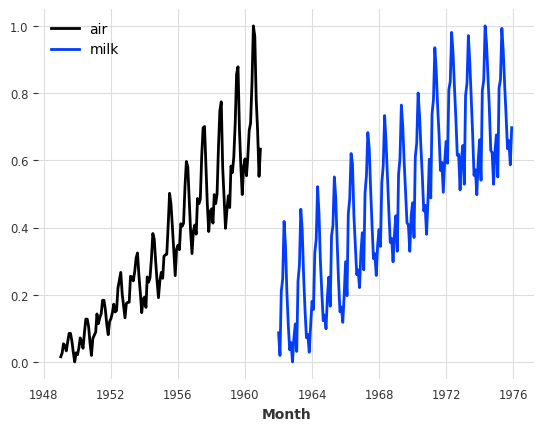

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_air, scaler_milk = Scaler(scaler), Scaler(scaler)
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

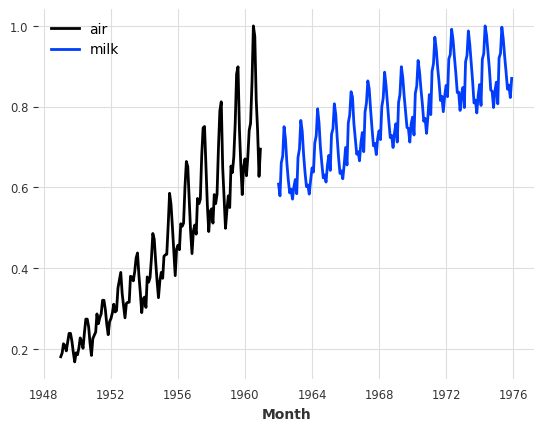

In [7]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler_air, scaler_milk = Scaler(scaler), Scaler(scaler)
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

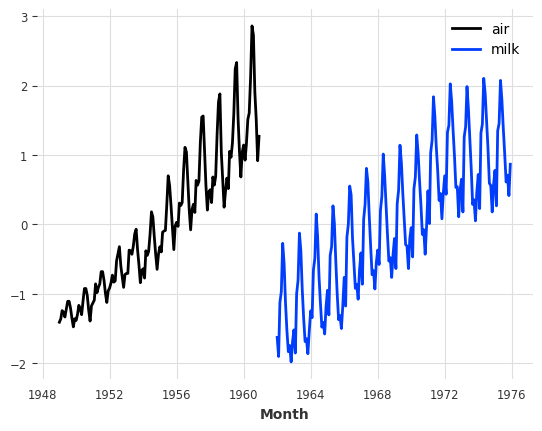

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_air, scaler_milk = Scaler(scaler), Scaler(scaler)
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

<Axes: xlabel='Month'>

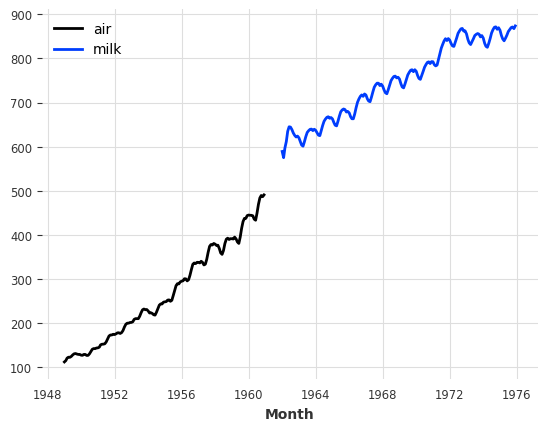

In [9]:
from darts.dataprocessing.transformers import WindowTransformer
# 롤링변환


# 이동 평균을 구하는 변환기 정의
transforms = [{
    "function": "mean",
    "mode": "rolling",
    "window": 10
}]


scaler_air, scaler_milk = WindowTransformer(transforms=transforms), WindowTransformer(transforms=transforms)
series_air_scaled = scaler_air.transform(series_air)
series_milk_scaled = scaler_milk.transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")


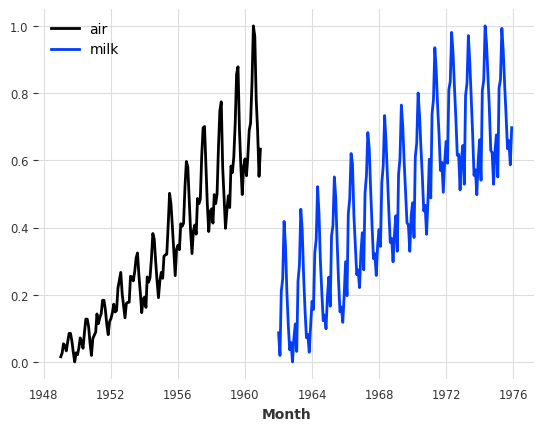

In [10]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

In [11]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [12]:
model_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=10,
    random_state=0,
    **generate_torch_kwargs()
)

In [13]:
model_air.fit(train_air)

Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s, train_loss=0.00982]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=10, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x000002335665CAA0>]})

MAPE = 26.05%


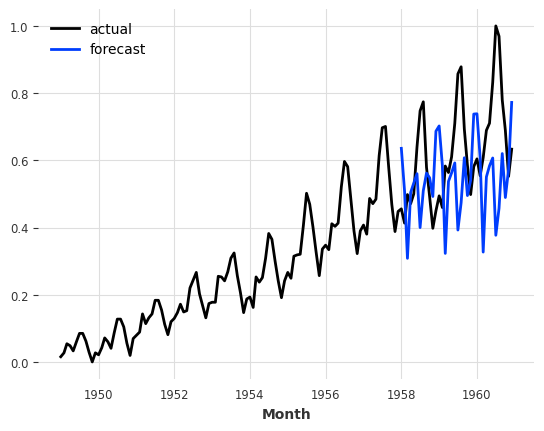

In [14]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

In [15]:
model_air_milk = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
    **generate_torch_kwargs()
)

In [16]:
model_air_milk.fit([train_air, train_milk])

Epoch 99: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s, train_loss=0.000362]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000023358D567E0>]})

MAPE = 7.58%


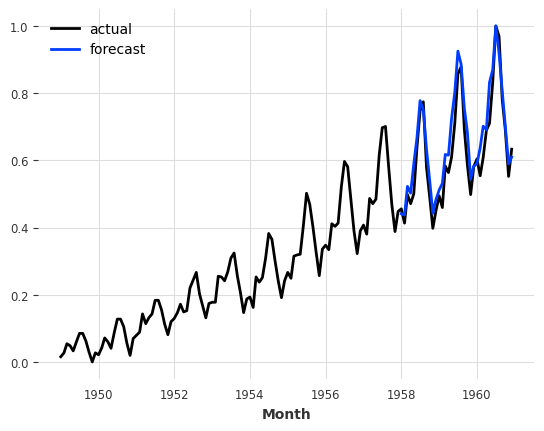

In [17]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

MAPE = 14.99%


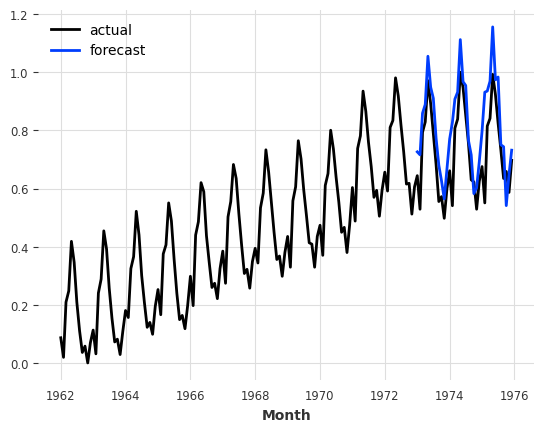

In [18]:
pred = model_air_milk.predict(n=36, series=train_milk)

series_milk_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_milk_scaled, pred)))

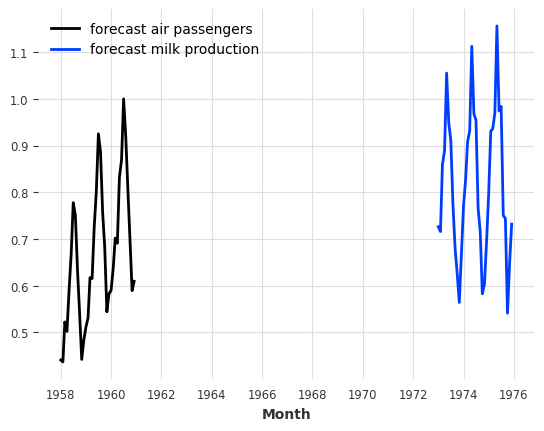

In [19]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend()

In [20]:
# 연, 월 데이터 추출
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")


milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

In [21]:
# stack year and month to obtain series of 2 dimensions (year and month):
# 공변량 추출
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

In [22]:
# scale them between 0 and 1:
scaler_covariates = Scaler()
air_train_covariates, milk_train_covariates = scaler_covariates.fit_transform(
    [air_train_covariates, milk_train_covariates]
)
air_val_covariates, milk_val_covariates = scaler_covariates.transform(
    [air_val_covariates, milk_val_covariates]
)

# concatenate for the full scaled series; we can feed this to model.fit()/predict() as Darts will extract the required covariates for you
air_covariates = concatenate([air_train_covariates, air_val_covariates])
milk_covariates = concatenate([milk_train_covariates, milk_val_covariates])

Text(0.5, 1.0, 'Milk production covariates (year and month)')

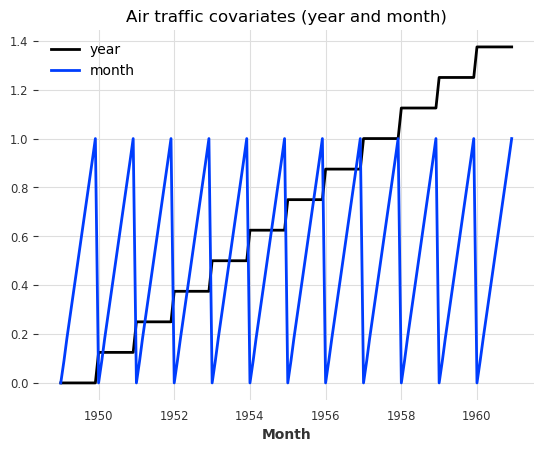

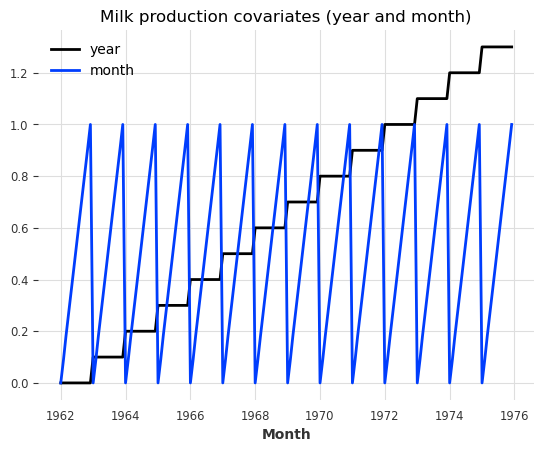

In [23]:
# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)")

In [24]:
model_name = "BlockRNN_test"
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **generate_torch_kwargs()
)

In [25]:
milk_covariates.time_index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq='MS')

In [26]:
model_pastcov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_covariates, milk_covariates],
    val_series=[val_air, val_milk],
    val_past_covariates=[air_covariates, milk_covariates],
)

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 23.24it/s, train_loss=0.00305, val_loss=0.00719]


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000023358D1A900>]})

In [27]:
model_pastcov = BlockRNNModel.load_from_checkpoint(model_name=model_name, best=True)


In [28]:
# 과거 공변량을 사용한 예측
model_pastcov

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000023358F3C860>]})

In [29]:
model_name = "RNN_test"
model_futcov = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=0,
    training_length=35,
    input_chunk_length=24,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **generate_torch_kwargs()
)

model_futcov.fit(
    series=[train_air, train_milk],
    future_covariates=[air_covariates, milk_covariates],
    val_series=[val_air, val_milk],
    val_future_covariates=[air_covariates, milk_covariates],
)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 47.10it/s, train_loss=0.00252, val_loss=0.00514] 


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=0, input_chunk_length=24, model_name=RNN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000023358F1AA20>]})

In [30]:
model_futurecov = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

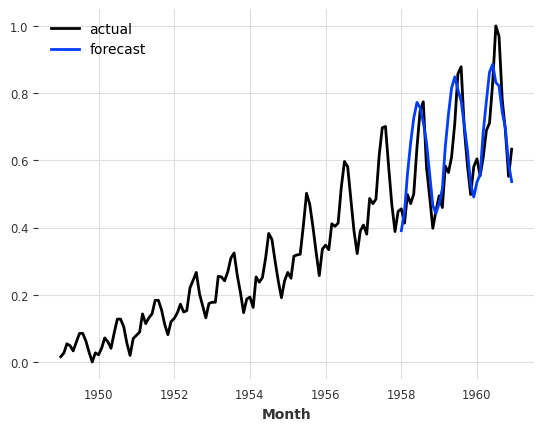

In [31]:
# air_covariate를 past_covariates로 넣어서 학습, n=36으로 예측, augo-regressive model하게 적용
pred_cov = model_pastcov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

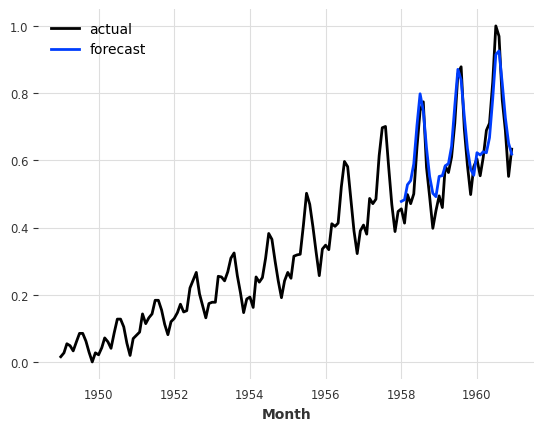

In [32]:
pred_cov = model_futcov.predict(
    n=36, series=train_air, future_covariates=air_covariates
)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

In [33]:
# backtest
backtest_pastcov = model_pastcov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=val_air.start_time(),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_pastcov = concatenate(backtest_pastcov)
print(
    "MAPE (BlockRNNModel with past covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_pastcov)
    )
)


MAPE (BlockRNNModel with past covariates) = 12.09%


In [34]:
backtest_futcov = model_futcov.historical_forecasts(
    series_air_scaled,
    future_covariates=air_covariates,
    start=val_air.start_time(),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_futcov = concatenate(backtest_futcov)
print(
    "MAPE (RNNModel with future covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_futcov)
    )
)

MAPE (RNNModel with future covariates) = 10.26%


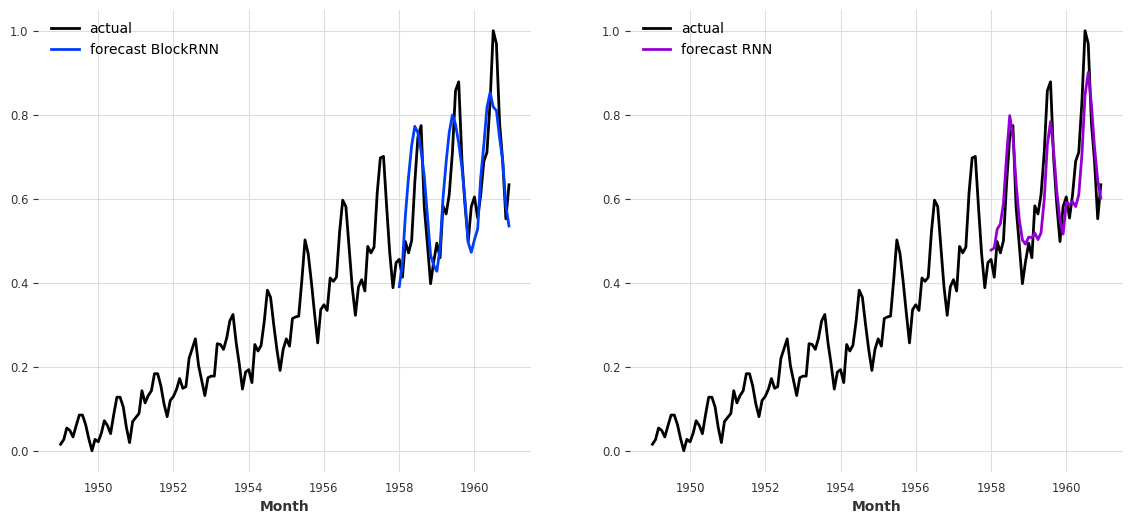

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
series_air_scaled.plot(label="actual", ax=axs[0])
backtest_pastcov.plot(label="forecast BlockRNN", ax=axs[0])
axs[0].legend()
series_air_scaled.plot(label="actual", ax=axs[1])
backtest_futcov.plot(label="forecast RNN", ax=axs[1], color="darkviolet")
axs[1].legend()
plt.show()

In [36]:
# 공변량은 동일한 시간대일 필요가 없음.
# TCNModel, NBEATSModel, BlockRNNModel, TransformerModel은 과거 공변량을 사용
# 과거 공변량이 미래에도 알려져 있는 경우, 이러한 모델은 자동회귀 방식으로 n > output_chunk_length에 대한 예측을 생성
# RNNModel은 미래 공변량을 사용. 이는 이 모델로 예측을 수행하려면 예측 시간 이후 적어도 n 시간 단계에 대한 공변량이 필요함.

In [37]:
# 다변량 시계열 학습
multi_serie_elec = ElectricityDataset().load()


In [38]:
multi_serie_elec.head()

<TimeSeries (DataArray) (Unnamed: 0: 5, component: 370, sample: 1)> Size: 15kB
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * Unnamed: 0  (Unnamed: 0) datetime64[ns] 40B 2011-01-01T00:15:00 ... 2011-...
  * component   (component) object 3kB 'MT_001' 'MT_002' ... 'MT_369' 'MT_370'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [39]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]

In [40]:
multi_serie_elec.time_index

DatetimeIndex(['2011-01-01 00:15:00', '2011-01-01 00:30:00',
               '2011-01-01 00:45:00', '2011-01-01 01:00:00',
               '2011-01-01 01:15:00', '2011-01-01 01:30:00',
               '2011-01-01 01:45:00', '2011-01-01 02:00:00',
               '2011-01-01 02:15:00', '2011-01-01 02:30:00',
               ...
               '2014-12-31 21:45:00', '2014-12-31 22:00:00',
               '2014-12-31 22:15:00', '2014-12-31 22:30:00',
               '2014-12-31 22:45:00', '2014-12-31 23:00:00',
               '2014-12-31 23:15:00', '2014-12-31 23:30:00',
               '2014-12-31 23:45:00', '2015-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=140256, freq='15min')

In [41]:

# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

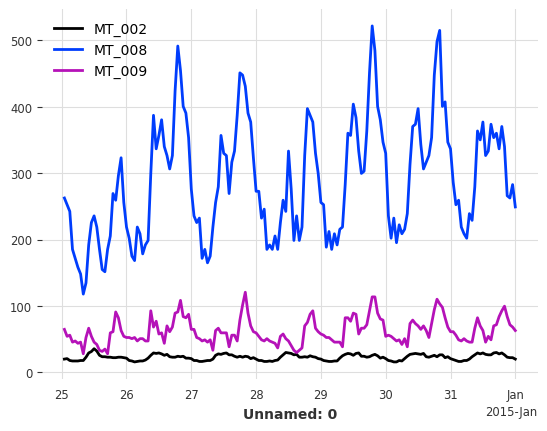

In [42]:
multi_serie_elec.plot()
plt.show()

In [43]:
# split in train/validation sets 6일, 1일로 나눔
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [44]:
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=200,
    **generate_torch_kwargs()
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

MAE (VARIMA) = 0.11
Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 10.67it/s, train_loss=0.00667]
MAE (RNN) = 0.10


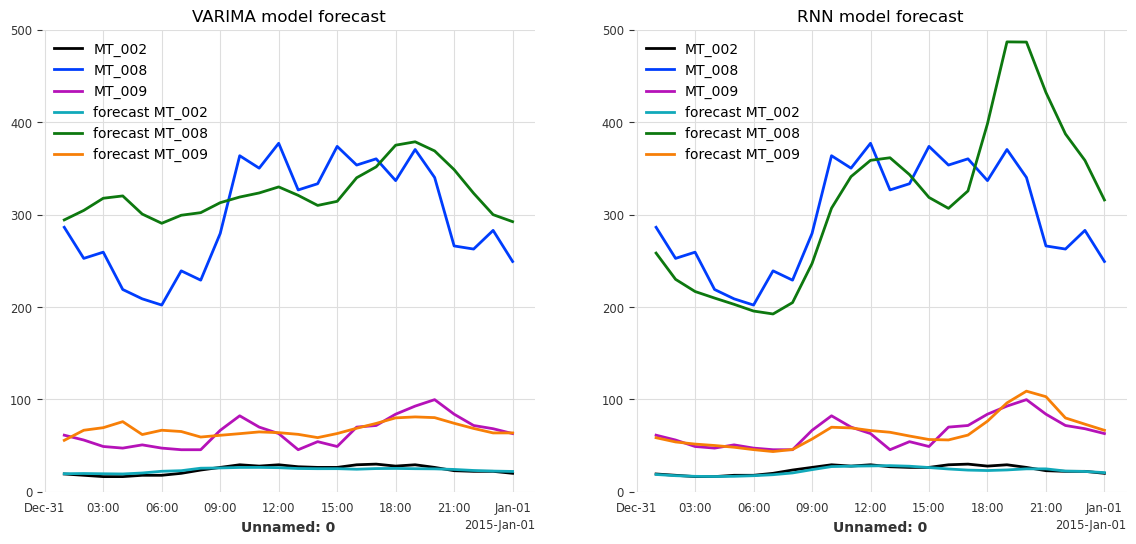

In [45]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()

In [46]:
train_air.time_index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1957-03-01', '1957-04-01', '1957-05-01', '1957-06-01',
               '1957-07-01', '1957-08-01', '1957-09-01', '1957-10-01',
               '1957-11-01', '1957-12-01'],
              dtype='datetime64[ns]', name='Month', length=108, freq='MS')

In [47]:
# time_index 불러오기
series_air.time_index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [48]:
# 3차원 형태로 변환  (time, component, sample)
imp = series_air.all_values()
imp.shape, imp[:5]

((144, 1, 1),
 array([[[112.]],
 
        [[118.]],
 
        [[132.]],
 
        [[129.]],
 
        [[121.]]]))

In [49]:
# 첫번째 값, 마지막 값
series_milk.first_values(), series_milk.last_values(), series_milk.start_time(), series_milk.end_time()

(array([589.]),
 array([843.]),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1975-12-01 00:00:00'))

In [50]:
# 평균값, 최대값, 최소값 axis 추가 가능
series_milk.mean()

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)> Size: 1kB
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 8B 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [51]:
series_milk.max()

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)> Size: 1kB
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 8B 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [52]:
series_milk.min()

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)> Size: 1kB
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 8B 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [54]:
series_milk.slice_intersect_times(series_air)
series_air.slice_intersect_values(series_milk)
series_air.slice_intersect_times(series_milk)
intersected_series = series_air.slice_intersect(series_milk)


In [55]:
# 빈도에 맞춰 Time stamp 생성
series_air.freq, series_air.end_time(), series_air.end_time() + series_air.freq

(<MonthBegin>,
 Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'))

In [56]:
# weekday 정보 추가
series_air.add_datetime_attribute("weekday")

<TimeSeries (DataArray) (Month: 144, component: 2, sample: 1)> Size: 2kB
array([[[112.],
        [  5.]],

       [[118.],
        [  1.]],

       [[132.],
        [  1.]],

       [[129.],
        [  4.]],

       [[121.],
        [  6.]],

       [[135.],
        [  2.]],

       [[148.],
        [  4.]],
...
       [[535.],
        [  2.]],

       [[622.],
        [  4.]],

       [[606.],
        [  0.]],

       [[508.],
        [  3.]],

       [[461.],
        [  5.]],

       [[390.],
        [  1.]],

       [[432.],
        [  3.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 16B '#Passengers' 'weekday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [57]:
# 달 정보 추가
series_air.add_datetime_attribute("month")

<TimeSeries (DataArray) (Month: 144, component: 2, sample: 1)> Size: 2kB
array([[[112.],
        [  0.]],

       [[118.],
        [  1.]],

       [[132.],
        [  2.]],

       [[129.],
        [  3.]],

       [[121.],
        [  4.]],

       [[135.],
        [  5.]],

       [[148.],
        [  6.]],
...
       [[535.],
        [  5.]],

       [[622.],
        [  6.]],

       [[606.],
        [  7.]],

       [[508.],
        [  8.]],

       [[461.],
        [  9.]],

       [[390.],
        [ 10.]],

       [[432.],
        [ 11.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 16B '#Passengers' 'month'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [58]:
# 한국 휴일 정보 추가
series_air.add_holidays("KR")

<TimeSeries (DataArray) (Month: 144, component: 2, sample: 1)> Size: 2kB
array([[[112.],
        [  1.]],

       [[118.],
        [  0.]],

       [[132.],
        [  1.]],

       [[129.],
        [  0.]],

       [[121.],
        [  0.]],

       [[135.],
        [  0.]],

       [[148.],
        [  0.]],
...
       [[535.],
        [  0.]],

       [[622.],
        [  0.]],

       [[606.],
        [  0.]],

       [[508.],
        [  0.]],

       [[461.],
        [  1.]],

       [[390.],
        [  0.]],

       [[432.],
        [  0.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 16B '#Passengers' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## 1분봉으로 데이터 확인

In [59]:
df = pd.read_csv('../dataset/btc_1m.csv', index_col=0)
df.drop_duplicates(inplace=True)

In [60]:
df.sort_values(by='open_time', inplace=True)

In [61]:
df.reset_index(drop=True, inplace=True)

In [64]:
# 1분 단위로 데이터 생성
bitcoin = TimeSeries.from_dataframe(df, 'open_time', fillna_value=0, freq='1min')
bitcoin.head()

<TimeSeries (DataArray) (open_time: 5, component: 6, sample: 1)> Size: 240B
array([[[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.77518300e+00],
        [7.56490685e+03]],

       [[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.28056000e+03],
        [4.28056000e+03],
        [4.28056000e+03],
        [4.28056000e+03],
        [2.61074000e-01],
        [1.11754292e+03]],

       [[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.20080000e-02],
        [5.11718518e+01]],

       [[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.40796000e-01],
        [5.99999338e+02]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [65]:
ck = pd.DataFrame(bitcoin.values())

In [66]:
ck.set_index(bitcoin.time_index, inplace=True)

In [67]:
ck.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [68]:
bitcoin.pd_dataframe()

component,open,high,low,close,volume,quote_asset_volume
open_time,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338
...,...,...,...,...,...,...
2023-07-17 14:38:00,30263.09,30268.53,30263.08,30268.52,5.295510,160263.391921
2023-07-17 14:39:00,30268.53,30268.53,30263.63,30263.64,6.420920,194342.819825
2023-07-17 14:40:00,30263.63,30263.64,30261.05,30261.06,13.007800,393657.249331


In [69]:
ck[ck.isna().any(axis=1)].index

DatetimeIndex([], dtype='datetime64[ns]', name='open_time', freq='min')

In [70]:
df_1 = df.set_index("open_time")

In [71]:
ck[ck.isna().any(axis=1)].index

DatetimeIndex([], dtype='datetime64[ns]', name='open_time', freq='min')

In [72]:
# 결측치 존재함
df.iloc[29500:29600].head(50)

,open_time,open,high,low,close,volume,quote_asset_volume
29500,2017-09-06 15:40:00,4546.78,4546.78,4546.78,4546.78,0.268884,1222.556394
29501,2017-09-06 15:41:00,4552.51,4560.00,4552.51,4560.00,0.510649,2326.547656
29502,2017-09-06 15:42:00,4552.60,4570.91,4552.60,4570.91,0.286066,1302.661016
29503,2017-09-06 15:43:00,4558.18,4570.91,4558.18,4570.91,1.021508,4665.805202
29504,2017-09-06 15:44:00,4580.47,4590.00,4580.47,4590.00,0.579058,2655.317053
29505,2017-09-06 15:45:00,4580.78,4592.47,4580.78,4592.47,1.702547,7814.160056
29506,2017-09-06 15:46:00,4582.31,4582.31,4582.31,4582.31,0.268152,1228.755591
29507,2017-09-06 15:47:00,4582.61,4594.90,4582.61,4594.90,1.878827,8629.728569
29508,2017-09-06 15:48:00,4584.12,4584.12,4584.12,4584.12,0.268025,1228.658763
29509,2017-09-06 15:49:00,4589.52,4597.80,4589.52,4597.80,0.272351,1249.990455


In [73]:
df.sort_values(by='open_time', inplace=True)

In [74]:
df.isna().sum()

open_time             0
open                  0
high                  0
low                   0
close                 0
volume                0
quote_asset_volume    0
dtype: int64

In [75]:
# 30분 단위로 데이터 변경
resampled_bitcoin = bitcoin.resample(freq="30min")

In [76]:
resampled_bitcoin.time_index

DatetimeIndex(['2017-08-17 04:00:00', '2017-08-17 04:30:00',
               '2017-08-17 05:00:00', '2017-08-17 05:30:00',
               '2017-08-17 06:00:00', '2017-08-17 06:30:00',
               '2017-08-17 07:00:00', '2017-08-17 07:30:00',
               '2017-08-17 08:00:00', '2017-08-17 08:30:00',
               ...
               '2023-07-17 10:00:00', '2023-07-17 10:30:00',
               '2023-07-17 11:00:00', '2023-07-17 11:30:00',
               '2023-07-17 12:00:00', '2023-07-17 12:30:00',
               '2023-07-17 13:00:00', '2023-07-17 13:30:00',
               '2023-07-17 14:00:00', '2023-07-17 14:30:00'],
              dtype='datetime64[ns]', name='open_time', length=103702, freq='30min')

In [77]:
bitcoin.time_index[30]

Timestamp('2017-08-17 04:30:00')

In [78]:
bitcoin[bitcoin.time_index[30]], resampled_bitcoin[bitcoin.time_index[30]]

(<TimeSeries (DataArray) (open_time: 1, component: 6, sample: 1)> Size: 48B
 array([[[4.28000000e+03],
         [4.28056000e+03],
         [4.27467000e+03],
         [4.28000000e+03],
         [1.69672300e+00],
         [7.25732219e+03]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 8B 2017-08-17T04:30:00
   * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (open_time: 1, component: 6, sample: 1)> Size: 48B
 array([[[4.28000000e+03],
         [4.28056000e+03],
         [4.27467000e+03],
         [4.28000000e+03],
         [1.69672300e+00],
         [7.25732219e+03]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 8B 2017-08-17T04:30:00
   * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hi

In [79]:
# 새로운 데이터 생성
values = np.random.rand(103702)
series1 = TimeSeries.from_times_and_values(resampled_bitcoin.time_index, values)


In [80]:
series1.time_index

DatetimeIndex(['2017-08-17 04:00:00', '2017-08-17 04:30:00',
               '2017-08-17 05:00:00', '2017-08-17 05:30:00',
               '2017-08-17 06:00:00', '2017-08-17 06:30:00',
               '2017-08-17 07:00:00', '2017-08-17 07:30:00',
               '2017-08-17 08:00:00', '2017-08-17 08:30:00',
               ...
               '2023-07-17 10:00:00', '2023-07-17 10:30:00',
               '2023-07-17 11:00:00', '2023-07-17 11:30:00',
               '2023-07-17 12:00:00', '2023-07-17 12:30:00',
               '2023-07-17 13:00:00', '2023-07-17 13:30:00',
               '2023-07-17 14:00:00', '2023-07-17 14:30:00'],
              dtype='datetime64[ns]', name='open_time', length=103702, freq='30min')

In [81]:
new_values = np.random.rand(103702)

In [82]:
updated_series = series1.with_times_and_values(resampled_bitcoin.time_index, new_values)


In [83]:
series1.head(), updated_series.head()

(<TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
 array([[[0.99718481]],
 
        [[0.93255736]],
 
        [[0.12812445]],
 
        [[0.99904052]],
 
        [[0.23608898]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
   * component  (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
 array([[[0.84494403]],
 
        [[0.38936258]],
 
        [[0.36872633]],
 
        [[0.95879364]],
 
        [[0.06962028]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
   * component  (component) object 8B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None)

In [84]:
# 데이터 타입 확인
resampled_bitcoin.is_probabilistic, resampled_bitcoin.is_deterministic

(False, True)

In [85]:
resampled_bitcoin.last_values()

array([3.02549500e+04, 3.02549500e+04, 3.02520000e+04, 3.02539900e+04,
       1.74491500e+01, 5.27912354e+05])

In [86]:
# 각 행의 최소값
resampled_bitcoin.min(axis=1)

<TimeSeries (DataArray) (open_time: 103702, component: 1, sample: 1)> Size: 830kB
array([[[ 1.775183]],

       [[ 1.696723]],

       [[ 0.      ]],

       ...,

       [[24.80981 ]],

       [[41.6556  ]],

       [[17.44915 ]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) object 8B 'components_min'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [87]:
series1

<TimeSeries (DataArray) (open_time: 103702, component: 1, sample: 1)> Size: 830kB
array([[[0.99718481]],

       [[0.93255736]],

       [[0.12812445]],

       ...,

       [[0.14156938]],

       [[0.57044161]],

       [[0.6324596 ]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [88]:
series1.head(), updated_series.head()

(<TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
 array([[[0.99718481]],
 
        [[0.93255736]],
 
        [[0.12812445]],
 
        [[0.99904052]],
 
        [[0.23608898]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
   * component  (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
 array([[[0.84494403]],
 
        [[0.38936258]],
 
        [[0.36872633]],
 
        [[0.95879364]],
 
        [[0.06962028]]])
 Coordinates:
   * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
   * component  (component) object 8B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None)

In [89]:
series1.concatenate(updated_series, axis=1)

<TimeSeries (DataArray) (open_time: 103702, component: 2, sample: 1)> Size: 2MB
array([[[0.99718481],
        [0.84494403]],

       [[0.93255736],
        [0.38936258]],

       [[0.12812445],
        [0.36872633]],

       ...,

       [[0.14156938],
        [0.14809123]],

       [[0.57044161],
        [0.0113514 ]],

       [[0.6324596 ],
        [0.84377465]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) <U3 24B '0' '0_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [90]:
# 각 열의 누적합
resampled_bitcoin.cumsum()

<TimeSeries (DataArray) (open_time: 103702, component: 6, sample: 1)> Size: 5MB
array([[[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.77518300e+00],
        [7.56490685e+03]],

       [[8.54148000e+03],
        [8.54204000e+03],
        [8.53615000e+03],
        [8.54148000e+03],
        [3.47190600e+00],
        [1.48222290e+04]],

       [[1.28503100e+04],
        [1.28508700e+04],
        [1.28449800e+04],
        [1.28503100e+04],
        [3.47190600e+00],
        [1.48222290e+04]],
...
       [[2.07070389e+09],
        [2.07235564e+09],
        [2.06916793e+09],
        [2.07081212e+09],
        [6.64236652e+06],
        [1.45953764e+11]],

       [[2.07073417e+09],
        [2.07238593e+09],
        [2.06919819e+09],
        [2.07084239e+09],
        [6.64240817e+06],
        [1.45955025e+11]],

       [[2.07076443e+09],
        [2.07241619e+09],
        [2.06922844e+09],
        [2.07087264e+09],
        [6.64242562e+06],
        [1.45955553e+11]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [91]:
resampled_bitcoin

<TimeSeries (DataArray) (open_time: 103702, component: 6, sample: 1)> Size: 5MB
array([[[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.77518300e+00],
        [7.56490685e+03]],

       [[4.28000000e+03],
        [4.28056000e+03],
        [4.27467000e+03],
        [4.28000000e+03],
        [1.69672300e+00],
        [7.25732219e+03]],

       [[4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [0.00000000e+00],
        [0.00000000e+00]],
...
       [[3.02447700e+04],
        [3.02500000e+04],
        [3.02192300e+04],
        [3.02272800e+04],
        [2.48098100e+01],
        [7.50044917e+05]],

       [[3.02866500e+04],
        [3.02940000e+04],
        [3.02650600e+04],
        [3.02679900e+04],
        [4.16556000e+01],
        [1.26141527e+06]],

       [[3.02549500e+04],
        [3.02549500e+04],
        [3.02520000e+04],
        [3.02539900e+04],
        [1.74491500e+01],
        [5.27912354e+05]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [92]:
# 변화율
resampled_bitcoin.diff().head()

<TimeSeries (DataArray) (open_time: 5, component: 6, sample: 1)> Size: 240B
array([[[ 1.85200000e+01],
        [ 1.90800000e+01],
        [ 1.31900000e+01],
        [ 1.85200000e+01],
        [-7.84600000e-02],
        [-3.07584659e+02]],

       [[ 2.88300000e+01],
        [ 2.82700000e+01],
        [ 3.41600000e+01],
        [ 2.88300000e+01],
        [-1.69672300e+00],
        [-7.25732219e+03]],

       [[ 1.11700000e+01],
        [ 1.11700000e+01],
        [ 1.11700000e+01],
        [ 1.11700000e+01],
        [ 1.79009000e-01],
        [ 7.73318880e+02]],

       [[-4.68000000e+00],
        [-4.68000000e+00],
        [-4.68000000e+00],
        [-4.68000000e+00],
        [-1.79009000e-01],
        [-7.73318880e+02]],

       [[-4.30000000e+00],
        [-4.30000000e+00],
        [-4.30000000e+00],
        [-4.30000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:30:00 ... 2017-08...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [93]:
# 변화율 2일간의
resampled_bitcoin.diff(n=2)

<TimeSeries (DataArray) (open_time: 103700, component: 6, sample: 1)> Size: 5MB
array([[[ 1.03100000e+01],
        [ 9.19000000e+00],
        [ 2.09700000e+01],
        [ 1.03100000e+01],
        [-1.61826300e+00],
        [-6.94973753e+03]],

       [[-1.76600000e+01],
        [-1.71000000e+01],
        [-2.29900000e+01],
        [-1.76600000e+01],
        [ 1.87573200e+00],
        [ 8.03064107e+03]],

       [[-1.58500000e+01],
        [-1.58500000e+01],
        [-1.58500000e+01],
        [-1.58500000e+01],
        [-3.58018000e-01],
        [-1.54663776e+03]],
...
       [[-9.11200000e+01],
        [-8.70100000e+01],
        [-1.39820000e+02],
        [-1.31780000e+02],
        [ 5.22089900e+01],
        [ 1.56846023e+06]],

       [[ 3.12000000e+00],
        [ 5.70000000e-01],
        [ 2.46000000e+01],
        [ 1.14400000e+01],
        [ 9.17273000e+00],
        [ 2.78915686e+05]],

       [[-7.35800000e+01],
        [-8.30500000e+01],
        [-5.88900000e+01],
        [-5.47100000e+01],
        [-4.10522400e+01],
        [-1.24487326e+06]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T05:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [94]:
resampled_bitcoin.time_index

DatetimeIndex(['2017-08-17 04:00:00', '2017-08-17 04:30:00',
               '2017-08-17 05:00:00', '2017-08-17 05:30:00',
               '2017-08-17 06:00:00', '2017-08-17 06:30:00',
               '2017-08-17 07:00:00', '2017-08-17 07:30:00',
               '2017-08-17 08:00:00', '2017-08-17 08:30:00',
               ...
               '2023-07-17 10:00:00', '2023-07-17 10:30:00',
               '2023-07-17 11:00:00', '2023-07-17 11:30:00',
               '2023-07-17 12:00:00', '2023-07-17 12:30:00',
               '2023-07-17 13:00:00', '2023-07-17 13:30:00',
               '2023-07-17 14:00:00', '2023-07-17 14:30:00'],
              dtype='datetime64[ns]', name='open_time', length=103702, freq='30min')

In [95]:
resampled_bitcoin.diff(n=2).time_index

DatetimeIndex(['2017-08-17 05:00:00', '2017-08-17 05:30:00',
               '2017-08-17 06:00:00', '2017-08-17 06:30:00',
               '2017-08-17 07:00:00', '2017-08-17 07:30:00',
               '2017-08-17 08:00:00', '2017-08-17 08:30:00',
               '2017-08-17 09:00:00', '2017-08-17 09:30:00',
               ...
               '2023-07-17 10:00:00', '2023-07-17 10:30:00',
               '2023-07-17 11:00:00', '2023-07-17 11:30:00',
               '2023-07-17 12:00:00', '2023-07-17 12:30:00',
               '2023-07-17 13:00:00', '2023-07-17 13:30:00',
               '2023-07-17 14:00:00', '2023-07-17 14:30:00'],
              dtype='datetime64[ns]', name='open_time', length=103700, freq='30min')

In [96]:
# t-2 데이터를 t로 데이터 이동
resampled_bitcoin.diff(periods=2)

<TimeSeries (DataArray) (open_time: 103700, component: 6, sample: 1)> Size: 5MB
array([[[ 4.73500000e+01],
        [ 4.73500000e+01],
        [ 4.73500000e+01],
        [ 4.73500000e+01],
        [-1.77518300e+00],
        [-7.56490685e+03]],

       [[ 4.00000000e+01],
        [ 3.94400000e+01],
        [ 4.53300000e+01],
        [ 4.00000000e+01],
        [-1.51771400e+00],
        [-6.48400331e+03]],

       [[ 6.49000000e+00],
        [ 6.49000000e+00],
        [ 6.49000000e+00],
        [ 6.49000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],
...
       [[ 1.68640000e+02],
        [ 1.73870000e+02],
        [ 1.82280000e+02],
        [ 1.90320000e+02],
        [-3.68628700e+01],
        [-1.10355090e+06]],

       [[ 8.06400000e+01],
        [ 8.74300000e+01],
        [ 6.70600000e+01],
        [ 6.99800000e+01],
        [ 2.45188500e+01],
        [ 7.43825013e+05]],

       [[ 1.01800000e+01],
        [ 4.95000000e+00],
        [ 3.27700000e+01],
        [ 2.67100000e+01],
        [-7.36066000e+00],
        [-2.22132563e+05]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T05:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [97]:
# 데이터 기간
resampled_bitcoin.duration

Timedelta('2160 days 10:30:00')

In [98]:
resampled_bitcoin.freq

<30 * Minutes>

In [99]:
# 행을 time index로 변환
resampled_bitcoin.get_timestamp_at_point(1)

Timestamp('2017-08-17 04:30:00')

In [100]:
resampled_bitcoin

<TimeSeries (DataArray) (open_time: 103702, component: 6, sample: 1)> Size: 5MB
array([[[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.77518300e+00],
        [7.56490685e+03]],

       [[4.28000000e+03],
        [4.28056000e+03],
        [4.27467000e+03],
        [4.28000000e+03],
        [1.69672300e+00],
        [7.25732219e+03]],

       [[4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [0.00000000e+00],
        [0.00000000e+00]],
...
       [[3.02447700e+04],
        [3.02500000e+04],
        [3.02192300e+04],
        [3.02272800e+04],
        [2.48098100e+01],
        [7.50044917e+05]],

       [[3.02866500e+04],
        [3.02940000e+04],
        [3.02650600e+04],
        [3.02679900e+04],
        [4.16556000e+01],
        [1.26141527e+06]],

       [[3.02549500e+04],
        [3.02549500e+04],
        [3.02520000e+04],
        [3.02539900e+04],
        [1.74491500e+01],
        [5.27912354e+05]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [101]:
resampled_bitcoin.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume'], dtype='object', name='component')

In [102]:
imp = resampled_bitcoin.copy()

In [109]:
updated_series = series.with_values(new_values[:36])

In [110]:
# map 함수를 이용한 데이터 변환
z = imp['open'].map(lambda x: x*100)

In [111]:
slice_test = updated_series.slice(updated_series.time_index[10], updated_series.time_index[20])
slice_test

<TimeSeries (DataArray) (Month: 11, component: 1, sample: 1)> Size: 88B
array([[[0.62935637]],

       [[0.9773655 ]],

       [[0.35827487]],

       [[0.25002369]],

       [[0.50907977]],

       [[0.3196371 ]],

       [[0.63838792]],

       [[0.43818773]],

       [[0.99759009]],

       [[0.19460787]],

       [[0.24797245]]])
Coordinates:
  * Month      (Month) datetime64[ns] 88B 1973-11-01 1973-12-01 ... 1974-09-01
  * component  (component) object 8B 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [104]:
# 같은 값만 추출
updated_series.slice_intersect(slice_test)

NameError: name 'slice_test' is not defined

In [105]:
# 겹치는 시간대
updated_series.slice_intersect_times(slice_test)

NameError: name 'slice_test' is not defined

In [112]:
imp.values()[0]

array([4.26148000e+03, 4.26148000e+03, 4.26148000e+03, 4.26148000e+03,
       1.77518300e+00, 7.56490685e+03])

In [113]:
# 같은 시간대에 stack
imp.stack(z).values()[0]

array([4.26148000e+03, 4.26148000e+03, 4.26148000e+03, 4.26148000e+03,
       1.77518300e+00, 7.56490685e+03, 4.26148000e+05])

In [114]:
transforms = [{
    "function": "mean",
    "mode": "rolling",
    "components" : 'close',
    "window": 3
}]

In [115]:
resampled_bitcoin

<TimeSeries (DataArray) (open_time: 103702, component: 6, sample: 1)> Size: 5MB
array([[[4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [4.26148000e+03],
        [1.77518300e+00],
        [7.56490685e+03]],

       [[4.28000000e+03],
        [4.28056000e+03],
        [4.27467000e+03],
        [4.28000000e+03],
        [1.69672300e+00],
        [7.25732219e+03]],

       [[4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [4.30883000e+03],
        [0.00000000e+00],
        [0.00000000e+00]],
...
       [[3.02447700e+04],
        [3.02500000e+04],
        [3.02192300e+04],
        [3.02272800e+04],
        [2.48098100e+01],
        [7.50044917e+05]],

       [[3.02866500e+04],
        [3.02940000e+04],
        [3.02650600e+04],
        [3.02679900e+04],
        [4.16556000e+01],
        [1.26141527e+06]],

       [[3.02549500e+04],
        [3.02549500e+04],
        [3.02520000e+04],
        [3.02539900e+04],
        [1.74491500e+01],
        [5.27912354e+05]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 830kB 2017-08-17T04:00:00 ... 2023-...
  * component  (component) object 48B 'open' 'high' ... 'quote_asset_volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [116]:
transformed_series = resampled_bitcoin.window_transform(transforms)

In [117]:
transformed_series.columns

Index(['rolling_mean_3_close'], dtype='object', name='component')

In [118]:
transformed_series.tail()

<TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
array([[[30139.28      ]],

       [[30134.98666667]],

       [[30154.08333333]],

       [[30231.09333333]],

       [[30249.75333333]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 40B 2023-07-17T12:30:00 ... 2023-07...
  * component  (component) <U20 80B 'rolling_mean_3_close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [119]:
resampled_bitcoin['close'].tail()

<TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
array([[[30036.96]],

       [[30198.01]],

       [[30227.28]],

       [[30267.99]],

       [[30253.99]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 40B 2023-07-17T12:30:00 ... 2023-07...
  * component  (component) object 8B 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [120]:
transformed_series.head(5)

<TimeSeries (DataArray) (open_time: 5, component: 1, sample: 1)> Size: 40B
array([[[4261.48      ]],

       [[4270.74      ]],

       [[4283.43666667]],

       [[4302.94333333]],

       [[4314.71666667]]])
Coordinates:
  * open_time  (open_time) datetime64[ns] 40B 2017-08-17T04:00:00 ... 2017-08...
  * component  (component) <U20 80B 'rolling_mean_3_close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [121]:
from darts.utils.statistics import extract_trend_and_seasonality  


In [122]:
resampled_bitcoin.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume'], dtype='object', name='component')

In [123]:
iii = pd.DataFrame(resampled_bitcoin.values())

In [124]:
iii[iii.isna()]

,0,1,2,3,4,5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
103697,NaN,NaN,NaN,NaN,NaN,NaN
103698,NaN,NaN,NaN,NaN,NaN,NaN
103699,NaN,NaN,NaN,NaN,NaN,NaN
103700,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
result = extract_trend_and_seasonality(resampled_bitcoin['open'])


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [593]:
extract_trend_and_seasonality(transformed_series)

ValueError: This function does not handle missing values